### 回归问题的加权融合

回归问题的加权融合是基于模型结果的，就是各个模型分别在全部数据集上进行训练和验证，得到最优模型，对测试集进行预测，然后，对各个模型测试集的预测值分配不同的权重，比较好的模型给与较大的权重，不好的模型你给予较小的权重

举例：下列是3个模型的预测值

In [263]:
from sklearn.metrics import mean_absolute_error
#生成一些简单的样本数据， test_prei代表第i个模型的预测值
test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表模型的真实值
y_test_true = [1, 3, 2, 6]

# 可以先看一下各个模型的预测结果
print('Pred1 MAE:',mean_absolute_error(y_test_true, test_pre1)) 
print('Pred2 MAE:',mean_absolute_error(y_test_true, test_pre2)) 
print('Pred3 MAE:',mean_absolute_error(y_test_true, test_pre3))

Pred1 MAE: 0.1750000000000001
Pred2 MAE: 0.07499999999999993
Pred3 MAE: 0.10000000000000009


In [264]:
# 加权融合
def Weighted_method(test_pre1, test_pre2, test_pre3, w=[1/3, 1/3, 1/3]):
    Weighted_result = w[0] * pd.Series(test_pre1) + w[1] * pd.Series(test_pre2) + w[2] * pd.Series(test_pre3)
    return Weighted_result

# 根据上面的MAE，我们计算每个模型的权重, 计算方式就是： wi = mae(i) / sum(mae)
pred1_mae = 0.17
pred2_mae = 0.075
pred3_mae = 0.1
ws = pred1_mae+pred2_mae+pred3_mae
w = [pred1_mae/ws,pred2_mae/ws,pred3_mae/ws]

Weighted_pre = Weighted_method(test_pre1,test_pre2,test_pre3,w) 
print('Weighted_pre MAE:',mean_absolute_error(y_test_true, Weighted_pre))   # 会发现这个效果会提高一些

Weighted_pre MAE: 0.09528985507246435


除了进行加权融合意外，还可以使用中位数和均值，这个均值是平均，而不是加权，而且这两种方法，效果还不怎么样，仅供参考

In [ ]:
## 定义结果的mean平均函数
def Mean_method(test_pre1,test_pre2,test_pre3):
    Mean_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).mean(axis=1)
    return Mean_result

## 定义结果的中位数平均函数
def Median_method(test_pre1,test_pre2,test_pre3):
    Median_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).median(axis=1)
    return Median_result

### 分类问题的投票融合

sklearn的投票法有2种类型，一种是直接输出类标签，另一种是输出类概率，使用前者进行投票叫做硬投票（Majority/Hard voting），使用后者进行投票叫做软投票（Soft Voting）。这个是通过VotingClassifier的voting参数进行控制的

硬投票其实是少数服从多数的方式，但是，有时候少数服从多数并不行，因为模型的得分不同。那么，就需要更合理的投票方式，就是权值投票方式

分类问题，他们的结果可以输出概率，也可以输出标签。
- 输出标签时，计算票数最多的类，该类为预测出来的类

- 输出为概率时，有两种方法进行投票：
    1. 比较每个模型中A和B的概率值，哪个大，就输出哪个类，比如有5个模型，有3个模型B类概率值大，那么 该样本预测值为B类【硬投票】
    2. 概率即为权重，A类为每个模型的概率值和，B类为每个模型的概率值和，哪个类的概率值大，就用输出哪个类【软投票】

硬投票是选择算法输出最多的标签，如果标签数量相等，那么按照升序进行选择，如下图所示
![avatar](./image/hard_voting.jpg)

硬投票对于某些模型对某类预测的概率严重高于某类，上图中，模型1和4对A的预测概率严重大于B，而其它三个模型的预测概率对B的预测概率只是勉强比A的概率值大，那么，使用硬投票方式就不太合理了，可以使用软投票

软投票使用各个算法输出的类概率进行类的选择，输入权重的话，会得到每个类的类概率的加权均值，值大的类会被选择
![avatar](./image/soft_voting.jpg)

使用soft voting时，把概率当作权重，这时候集成后的结果为A就显得更为合理

#### hard voting投票

In [266]:
from sklearn.datasets import load_iris

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

iris =load_iris()

x=iris.data
y=iris.target
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.7,
                     colsample_bytree=0.6, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63,oob_score=True)
clf3 = SVC(C=0.1, probability=False)  # 软投票的时候，probability必须指定且为true

# 硬投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Voting']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.95 (+/- 0.03) [SVM]
Accuracy: 0.96 (+/- 0.02) [Voting]


#### soft voting软投票

In [267]:
from sklearn.datasets import load_iris

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

iris =load_iris()

x=iris.data
y=iris.target
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.7,
                     colsample_bytree=0.6, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63,oob_score=True)
clf3 = SVC(C=0.1, probability=True)  # 软投票的时候，probability必须指定且为true

# 软投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')
for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Voting']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.95 (+/- 0.03) [SVM]
Accuracy: 0.96 (+/- 0.02) [Voting]


## 模型融合-stacking

### stacking

stacking是一种融合方法，可以叠加很多层进行融合，下面以两层为例对stacking进行介绍。

stacking对若干基模型进行交叉验证，将得到的预测结果进行拼接，作为次级模型的输入，同时，当每个基模型训练好后，需要对测试数据预测，使用训练好的次级模型对测试数据再进行预测。

如下图所示，存在3个基模型，对每个模型进行五折交叉验证，每一折中，对验证集和测试集同时预测，五折后，将基模型的验证集的预测值进行纵向拼接，得到训练集大小的预测值，该值作为会成为新特征；而将得到的五份测试数据的预测值在横向上计算平均值或者加权平均，得到的均值作为测试集的预测值。

对3个基模型分别进行五折交叉验证后，将验证集预测值拼接和对测试集均值计算后，将验证集拼接而成的预测值作为新特征，使用新特征训练次级模型，使用训练好的次级模型对测试集的均值进行计算，而不是对源测试集进行预测。
最后得到的预测结果，即为对数据集的预测

代码文件和图片文件在同一个目录下
![title](./image/stackings.png)

以下是对stacking融合的代码实现

功能流程：
- 对鸢尾花数据进行3分类
- 将其切分为训练集和测试集【因为数据比较少，所以验证集和测试集相同，代码中统称为为测试集】
- xgb和lgb作为基模型，分别预测概率，而不是预测标签
- 将xgb和lgb的预测结果进行拼接和计算，训练svm次级模型，进而预测标签

In [11]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import StratifiedKFold, KFold

In [9]:
# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
#切分一部分数据作为测试集
x_train,x_test,y_train,y_text = train_test_split(X, y, test_size=0.2, random_state=914)

In [18]:
x_train.shape

(120, 2)

In [19]:
y_text.shape

(30,)

In [173]:
class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,3)) 
        oof_test = []
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        KF = KFold(n_splits = n_folds, random_state=2017)
        for i, (train_index, val_index) in enumerate(KF.split(x_train)):
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            model, auc = self.train(x_tra, y_tra, x_val, y_val)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test.append(self.predict(model, x_test))
        oof_test = np.mean(np.hstack(oof_test), axis=1)
#         print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test

In [174]:
import lightgbm as lgb
class LGBClassifier(BasicModel):
    def __init__(self):
        self.num_boost_round = 2000
        self.early_stopping_rounds = 15
        self.params = {
            'task': 'train',
            'boosting_type': 'gbdt',
#             'objective': 'binary',
            'objective': 'multiclass',
            'metric': 'multi_error',
            'num_leaves': 80,
            'learning_rate': 0.05,
            # 'scale_pos_weight': 1.5,
            'feature_fraction': 0.5,
            'bagging_fraction': 1,
            'bagging_freq': 5,
            'max_bin': 300,
            'is_unbalance': True,
            'lambda_l2': 5.0,
            'verbose' : -1,
            'num_class':3
            }
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets = lgbval,
                          verbose_eval = self.num_boost_round,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        a=model.predict(x_test, num_iteration=model.best_iteration)
#         print(a.shape)
        return a

In [175]:
# get output of first layer models and construct as input for the second layer          
lgb_classifier = LGBClassifier()
lgb_oof_train, lgb_oof_test = lgb_classifier.get_oof(x_train, y_train, x_test)
print(lgb_oof_train.shape, lgb_oof_test.shape) 

0 fold, train 96, val 24
train with lgb model
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_error: 0.416667
test with lgb model
test with lgb model
1 fold, train 96, val 24
train with lgb model
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_error: 0.458333
test with lgb model
test with lgb model
2 fold, train 96, val 24
train with lgb model
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_error: 0.583333
test with lgb model
test with lgb model
3 fold, train 96, val 24
train with lgb model
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_error: 0.541667
test with lgb model
test with lgb model
4 fold, train 96, val 24
train with lgb model
Training until validation scores don't improve for 15 rounds
Early stopping, best 

In [177]:
# create two models for first-layer stacking: xgb and lgb
import xgboost as xgb
class XGBClassifier(BasicModel):
    def __init__(self):
        """set parameters"""
        self.num_rounds=1000
        self.early_stopping_rounds = 15
        self.params = {
#             'objective': 'binary:logistic',
            'objective': 'multi:softprob',
            'eta': 0.1,
            'max_depth': 8,
#             'eval_metric': 'auc',
            'metric': 'multi_error',
            'seed': 0,
            'silent' : 1,
            'num_class':3
            
         }
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with xgb model')
        xgbtrain = xgb.DMatrix(x_train, y_train)
        xgbval = xgb.DMatrix(x_val, y_val)
        watchlist = [(xgbtrain,'train'), (xgbval, 'val')]
        model = xgb.train(self.params, 
                          xgbtrain, 
                          self.num_rounds,
                          watchlist,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, float(model.eval(xgbval).split()[1].split(':')[1])

    def predict(self, model, x_test):
        print('test with xgb model')
        xgbtest = xgb.DMatrix(x_test)
        return model.predict(xgbtest)

In [178]:
xgb_classifier = XGBClassifier()
xgb_oof_train, xgb_oof_test = xgb_classifier.get_oof(x_train, y_train, x_test)
print(xgb_oof_train.shape, xgb_oof_test.shape)

0 fold, train 96, val 24
train with xgb model
[18:31:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { metric, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.04167	val-merror:0.08333
Multiple eval metrics have been passed: 'val-merror' will be used for early stopping.

Will train until val-merror hasn't improved in 15 rounds.
[1]	train-merror:0.04167	val-merror:0.08333
[2]	train-merror:0.04167	val-merror:0.08333
[3]	train-merror:0.04167	val-merror:0.08333
[4]	train-merror:0.04167	val-merror:0.08333
[5]	train-merror:0.04167	val-merror:0.08333
[6]	train-merror:0.04167	val-merror:0.08333
[7]	train-merror:0.04167	val-merror:0.08333
[8]	train-merror:0.04167	val-merror:0.08333
[9]	train-merror:0.04

In [207]:
input_train = [xgb_oof_train, lgb_oof_train] 
input_test = np.array([xgb_oof_test, lgb_oof_test]).T
input_test.shape

(30, 2)

In [209]:
stacked_train = np.concatenate(input_train, axis=1)
stacked_test = input_test

print(stacked_train.shape, stacked_test.shape)

(120, 6) (30, 2)


In [210]:
# use LR as the model of the second layer
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [214]:
from sklearn import svm

In [ ]:
# split for validation
n = int(stacked_train.shape[0] * 0.8)
x_tra, y_tra = stacked_train[:n], y_train[:n]
x_val, y_val = stacked_train[n:], y_train[n:]

In [220]:
# 输出标签
clf = svm.SVC(decision_function_shape='ovo',probability=False)
clf.fit(x_tra,y_tra)
y_pred=clf.predict(x_val)

In [217]:
# 输出概率
clf = svm.SVC(decision_function_shape='ovo',probability=True)
clf.fit(x_tra,y_tra)
y_pred=clf.predict_proba(x_val)

array([[0.94063807, 0.03245605, 0.02690587],
       [0.94063807, 0.03245605, 0.02690587],
       [0.94063807, 0.03245605, 0.02690587],
       [0.01554226, 0.53502404, 0.44943371],
       [0.01126673, 0.91413412, 0.07459915],
       [0.01131326, 0.91407162, 0.07461512],
       [0.01191187, 0.09403685, 0.89405128],
       [0.01170821, 0.09416351, 0.89412828],
       [0.93953054, 0.03317928, 0.02729018],
       [0.93906664, 0.03347105, 0.02746231],
       [0.01124835, 0.91409274, 0.07465891],
       [0.93953054, 0.03317928, 0.02729018],
       [0.01170821, 0.09416351, 0.89412828],
       [0.01191187, 0.09403685, 0.89405128],
       [0.01084207, 0.9026358 , 0.08652213],
       [0.01176141, 0.094129  , 0.89410959],
       [0.93953054, 0.03317928, 0.02729018],
       [0.01176141, 0.094129  , 0.89410959],
       [0.93906664, 0.03347105, 0.02746231],
       [0.94063807, 0.03245605, 0.02690587],
       [0.94063807, 0.03245605, 0.02690587],
       [0.01091375, 0.90341611, 0.08567014],
       [0.

In [223]:
y_pred,y_val

(array([0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1,
        1, 2]),
 array([0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1,
        2, 2]))

In [241]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, confusion_matrix,roc_auc_score

In [236]:
sw = compute_sample_weight(class_weight='balanced',y=y_val)
cm =confusion_matrix(y_val, y_pred, sample_weight=sw)
cm

array([[8., 0., 0.],
       [0., 8., 0.],
       [0., 1., 7.]])

In [211]:
# 并没有用逻辑回归做鸢尾花的多分类
# 逻辑回归
model = LinearRegression()
model.fit(x_tra,y_tra)

y_pred = model.predict(x_val)
print(metrics.roc_auc_score(y_val, y_pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

stacking:

1. stacking的原理介绍：https://wulc.me/2018/01/21/stacking%20%E7%9A%84%E5%9F%BA%E6%9C%AC%E6%80%9D%E6%83%B3%E5%8F%8A%E4%BB%A3%E7%A0%81%E5%AE%9E%E7%8E%B0/
2. stacking项目：https://github.com/WuLC/MachineLearningAlgorithm/blob/master/python/Stacking.py

svc:https://blog.csdn.net/BabyBirdToFly/article/details/72886879

xgb,lgb：https://www.cnblogs.com/nxf-rabbit75/p/9748345.html

xgb，lgb参数介绍：https://www.jianshu.com/p/1100e333fcab

逻辑回归多分类：https://blog.csdn.net/weixin_39541558/article/details/80621692

鸢尾花多分类：https://blog.csdn.net/golden1314521/article/details/46564227

macro,micro评价指标：https://zhuanlan.zhihu.com/p/59862986

#### stacking融合方法
以上是手动实现stacking融合，mlxtend方法提供了一种stacking的方法，可以直接进行融合，而不用管基模型是如何预测数据，以及如何训练次级模型的

sclf = StackingClassifier([基模型],meta_classfier=次级模型)是stacking融合方法，选择好基模型和次级模型后，将sclf当作普通的模型，使用数据对其进行训练就可以。

这个方法就完成了我们前面实现的stacking操作，是不是很简单，嘻嘻~

Accuracy: 0.91 (+/- 0.07) [KNN]


TypeError: axis() got an unexpected keyword argument 'y_min'

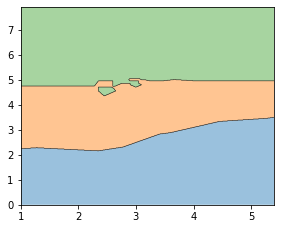

In [246]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions


# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target


clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)


label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)


clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

使用plot_decision_regions会报错，可能是因为我使用的mlxtend版本有点低，版本为0.16，可以用比较新的版本看看

### blending
#### 1. 单纯的Holdeout

blending：将数据集分为三部分：训练集，验证集，测试集，不涉及交叉验证，使用训练集分别训练5个基模型，对验证集和测试集进行预测，将5个模型得到的预测值进行横向拼接，其中，验证集的预测值为次级模型的新特征，测试集的预测值为次级模型的测试集，然后，使用验证集形成的新特征训练次级模型Model6，用训练好的次级模型对基模型的测试集进行预测，而不是对源测试集预测。

![avatar](./image/blending-solo.jpg)

In [239]:
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier

In [242]:
# 以python自带的鸢尾花数据集为例
data_0 = iris.data
data = data_0[:100,:]


target_0 = iris.target
target = target_0[:100]
 
#模型融合中基学习器
clfs = [LogisticRegression(),
        RandomForestClassifier(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier()]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=914)


#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=914)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))


#融合使用的模型
clf = GradientBoostingClassifier()
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
Val auc Score of Blending: 1.000000


#### 2. blending(holdout交叉)

这里的blending时引入了交叉验证的那种思想，也就是每个模型看到的Holdout集合不一样。
和stacking流程类似，只不过这里是用到了交叉验证的思想

> blending融合过程
- 在第一层上，将数据集交叉划分，在不同的模型上进行训练，即，n折交叉需要n个不同的模型，最后将模型对验证集的预测值纵向拼接，就可以得到和训练集长度一致的预测值，这个过程相当于对训练集进行了预测；

1. 将数据分成5份，第一份为验证集，其它份为训练集，训练Model1，对第一份验证集进行预测
2. 第二份为验证集，其它份为训练集，训练Model2，然后，用model2没模型对第二份验证集进行预测
3. 第三份为验证集，其它份为训练集，训练Model3，然后，用model2没模型对第三份验证集进行预测
4. 第四份为验证集，其它份为训练集，训练Model4，然后，用model2没模型对第四份验证集进行预测
5. 第五份为验证集，其它份为训练集，训练Model5，然后，用model2没模型对第五份验证集进行预测



![avatar](./image/blending-cv.jpg)

In [ ]:
# 模型融合中用到的单个模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

# 切分一部分数据作为训练集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

dataset_blend_train = np.zeros((int(X.shape[0]/n_splits), len(clfs)))   # 每个模型的预测作为第二层的特征
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

# 5折stacking
n_splits = 5
skf = StratifiedKFold(n_splits)
skf = skf.split(X, y)

fold = {}
for i, (train, test) in enumerate(skf):
    fold[i] = (X[train], y[train], X[test], y[test])
    
Y_blend = []
for j, clf in enumerate(clfs):
    # 依次训练各个单模型
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    
    # 5——fold交叉训练，使用第i个部分作为预测， 剩余的部分来训练模型， 获得其预测的输出作为第i部分的新特征。
    X_train, y_train, X_test, y_test = fold[j]
    clf.fit(X_train, y_train)
    dataset_blend_train[:, j] =  clf.predict(X_test)
    Y_blend.extend(y_test)
    
    # 对于测试集，直接用这k个模型的预测值作为新的特征
    dataset_blend_test[:, j] = clf.predict(X_predict)
        
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_blend_test[:, j]))

# T是转置，行变列，列变行，reshpae按照行，不断抽取n个数据，共70行，若是数据集有70个元素，那么，n=-1,若是有140个元素，n=2   
dataset_blend_train = dataset_blend_train.T.reshape(70, -1)
dataset_blend_test = np.mean(dataset_blend_test, axis=1).reshape(-1, 1)
Y_blend = np.array(Y_blend).reshape(-1, 1)

clf = LogisticRegression(solver='lbfgs')
clf.fit(dataset_blend_train, Y_blend)
y_submission = clf.predict(dataset_blend_test)

print("Val auc Score of Stacking: %f" % (roc_auc_score(y_predict, y_submission)))


模型调参是在全量数据集上实现的，那使用stacking进行模型融合时，会不会对模型产生影响

模型调参也分了训练集和测试集，在stacking时，将数据进行交叉融合就可以

那会不会因为数据分布的不同，对模型产生不好的影响

## 融合总结

从模型的结果， 样本集的集成和模型自身融合三个方面去整理.
- 模型的结果方面，对于回归问题，我们可以对模型的结果进行加权融合等方式使得结果更好;对于分类问题，我们可以使用Voting的方式去得到最终的结果。 
- 样本集的集成技术方面，我们学了Boosting和Bagging方式， 都是把多个弱分类器进行集成的技术， 但是两者是不同的。

- 模型自身的融合方面， 我们学习了Stacking和Blending的原理及具体实现方法，介绍了mlxtend库里面的模型融合工具。

![avatar](./image/融合.jpg)

比赛的融合这个问题，个人的看法来说其实涉及多个层面，也是提分和提升模型鲁棒性的一种重要方法：

1. 结果层面的融合，这种是最常见的融合方法，其可行的融合方法也有很多，比如根据结果的得分进行加权融合，还可以做Log，exp处理等。在做结果融合的时候，有一个很重要的条件是模型结果的得分要比较近似，然后结果的差异要比较大，这样的结果融合往往有比较好的效果提升。
2. 特征层面的融合，这个层面其实感觉不叫融合，准确说可以叫分割，很多时候如果我们用同种模型训练，可以把特征进行切分给不同的模型，然后在后面进行模型或者结果融合有时也能产生比较好的效果。
3. 模型层面的融合，模型层面的融合可能就涉及模型的堆叠和设计，比如加Staking层，部分模型的结果作为特征输入等，这些就需要多实验和思考了，基于模型层面的融合最好不同模型类型要有一定的差异，用同种模型不同的参数的收益一般是比较小的。

### Blending和stacking的不同

> stacking
- stacking中由于两层使用的数据不同，所以可以避免信息泄露的问题
- 在组队竞赛的过程中，不需要给队友分享自己的随机种子

> Blending
- 由于blending将数据分为了两部分，在最后预测时，有部分数据信息将被忽略
- 同时，在使用第二层数据时，可能会因为第二层数据较少，产生过拟合现象

### 参考链接

1. 对各种模型融合进行了详细的介绍：https://blog.csdn.net/wuzhongqiang/article/details/105012739